# Image recognition of Anderson states

## Preliminaries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import fastai
from fastai.vision import *
#from fastai.metrics import error_rate

In [4]:
#bs = 64
bs = 16  # uncomment this line if you run out of memory even after clicking Kernel->Restart
myepoch0 = 4
myepoch1 = 2
myepoch2 = 2

## Reading in the image data

In [5]:
path = Path(' /storage/disqs/UG-phaseML/data/')

In [6]:
path.ls()

FileNotFoundError: ignored

In [ ]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay].append(float(line))
        #print(float(line))
        col += 1
    return system
        

In [ ]:
import os

data   = []
labels = []

datasrc = '/home/epp/phupqr/PX319MLPhases/MachineLearning-Anderson/raw_system_data_refs' #Source of the locations of the data

disorder_systems      = []
disorder_class_labels = []

for disorder_class_folder in os.scandir(datasrc):                #Go through each of the disorder folders...
    print(disorder_class_folder.path)
    disorder_class = disorder_class_folder.path.rsplit('_',1)[1];
    print(disorder_class)
    disorder_systems.append([])
    disorder_class_labels.append(disorder_class)
    
    for file in os.scandir(disorder_class_folder.path):          #...find the file in each folder...
        #print(file)                                             #...
        the_file = open(file.path, 'r')                          #...open the file to read the locations of the data...
        
        number_of_data = 0
        for line in the_file:                                    #...for each... 
            
            if (number_of_data < 1):                           #...gather a certain amount of data...
                print(" ")
                number_of_data += 1

                #print(line)
                line = line.rsplit('\n',1)[0]
                raw_data = open(line,'r')
                system = make_3D_structure(raw_data, 20)
                #print(system)
                disorder_systems[-1].append(system)
                print("added system to " + disorder_class_labels[-1])
     


In [7]:
class ThreeDDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.c = len(self.y)
        self.is_empty=(len(x)==0)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y[i]
        

In [13]:
#Data from the path
#np.random.seed(1234567)
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        #ds_tfms=get_transforms(do_flip=False,max_rotate=0.,max_warp=0.,max_zoom=1.0,max_lighting=None), 
                                  #size=256, num_workers=4).normalize(imagenet_stats)
        
N = 10    #Number of sample 3D systems
tensors = []
for i in range(N):
    ten = [
        [
            [1,1,1],    
            [1,1,1],    #Layer 0
            [1,1,1]
        ],
        [
            [1,1,1],
            [1,1,1],    #Layer 1
            [1,1,1]
        ],
        [
            [1,1,1],
            [1,1,1],    #Layer 2
            [1,1,1]
        ]
    ]
    tensors.append(ten)
tensors = torch.Tensor(tensors)
print(tensors[0])

labels = []
for i in range(N):
  labels.append(random.randint(0,N-1))
labels = torch.tensor(labels)
print(labels)

loader = ThreeDDataset(tensors,labels)

databunch = DataBunch.create(loader, loader, bs=2, num_workers=5)

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])
tensor([2, 4, 2, 2, 6, 1, 9, 3, 4, 4])


## Train model

In [14]:
learn = cnn_learner(databunch, models.resnet50, metrics=error_rate, pretrained=False)#.to_fp16()

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [16]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 2, 2]           9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 2, 2]           128        True      
______________________________________________________________________
ReLU                 [64, 2, 2]           0          False     
______________________________________________________________________
MaxPool2d            [64, 1, 1]           0          False     
______________________________________________________________________
Conv2d               [64, 1, 1]           4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 1, 1]           128        True      
______________________________________________________________________
Conv2d               [64, 1, 1]           36,864     True      
___________________________________________________

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


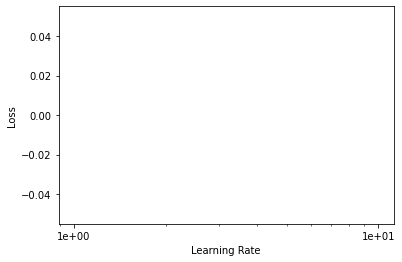

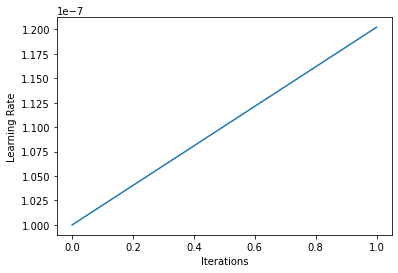

In [17]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

In [18]:
lr=1.e-2

In [19]:
learn.fit_one_cycle(myepoch0,lr)

epoch,train_loss,valid_loss,error_rate,time
0,-0.013009,-12.634160,0.700000,00:05
1,-0.128510,-127876.703125,0.700000,00:05
2,-0.375466,-4541098496.000000,0.900000,00:05
3,-0.648592,-308629169242112.000000,0.900000,00:05


In [20]:
learn.save('stage-0')

In [21]:
learn.show_results()

AttributeError: ignored

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


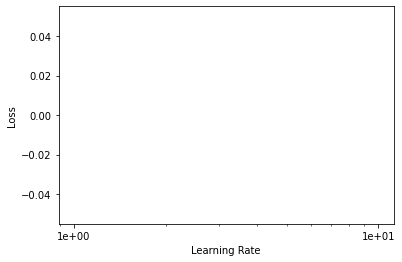

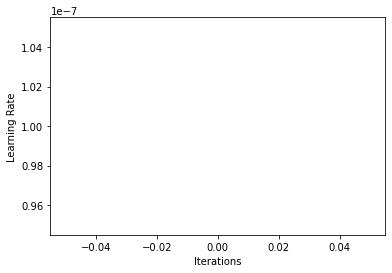

In [22]:
learn.lr_find()
learn.recorder.plot()
learn.recorder.plot_lr()

## Heatmap

In [26]:
idx=0
x,y = loader.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

AttributeError: ignored

In [27]:
m = learn.model.eval();

In [25]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

NameError: ignored

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

## refining the model - stage 1

In [28]:
learn.load('stage-0');

In [29]:
learn.unfreeze()

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


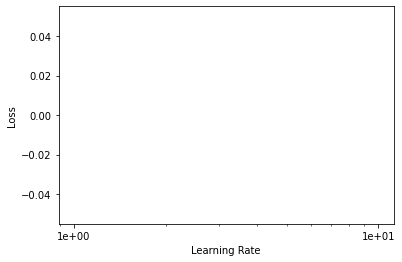

In [31]:
learn.recorder.plot()
#learn.recorder.plot_losses()
# learn.recorder.plot_lr()

In [32]:
learn.fit_one_cycle(myepoch1, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,-1.349319,-31214378648560730112.000000,0.900000,00:07
1,-1.406805,-15166418374078517001322496.000000,0.900000,00:05


In [ ]:
learn.save('stage-1')

## refining the model further - stage 2

In [ ]:
learn.load('stage-1');
learn.unfreeze();
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(myepoch2, max_lr=slice(3e-6,1e-5))

In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-0');

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

AttributeError: ignored

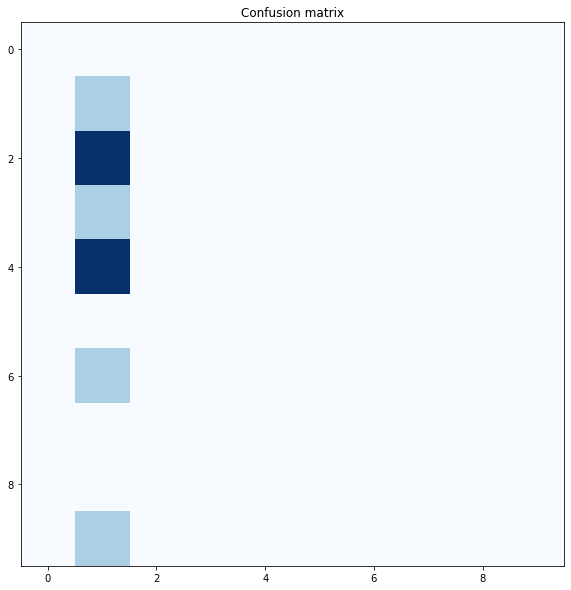

In [35]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))